# Vanilla Autoencoder


## IMPORT

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import random
import cv2
from collections import Counter  # Import Counter at the top
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


## LOAD DATA

In [3]:
# Path to the extracted dataset
extracted_path = 'Desktop/CV/milestone_2'

# Maximum number of classes to use
max_classes = 100

# Function to load images and labels
def load_casia_webface_data(dataset_path, max_classes=max_classes):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    # Walk through dataset directories
    for subdir, dirs, _ in os.walk(dataset_path):
        for dir_name in sorted(dirs):  # Sorting for consistency
            if current_label >= max_classes:
                break  # Stop after reaching max_classes

            identity_dir = os.path.join(subdir, dir_name)
            label_map[current_label] = dir_name  # Map label to identity
            # print(f"Processing identity: {dir_name} (Label {current_label})")

            # Process all images in the identity's folder
            for img_file in os.listdir(identity_dir):
                img_path = os.path.join(identity_dir, img_file)

                # Skip non-image files
                if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Load and preprocess the image
                img = cv2.imread(img_path)
                if img is None:
                    # print(f"Warning: Unable to read image {img_path}")
                    continue

                img = cv2.resize(img, (64, 64))  # Resize to 64x64 (or the desired size)
                images.append(img)
                labels.append(current_label)

            current_label += 1

        if current_label >= max_classes:
            break

    if not images:
        raise ValueError("No images were loaded. Please check the dataset structure and image paths.")

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    return images, labels, label_map

# Load dataset
try:
    images, labels, label_map = load_casia_webface_data(extracted_path, max_classes=max_classes)
    print(f"Loaded {images.shape[0]} images with {len(label_map)} identities.")
except ValueError as e:
    print(f"Error: {e}")


Loaded 14650 images with 100 identities.


## Normalize the features by subtracting the mean and dividing by the standard deviation for each channel


In [7]:
mean = np.mean(images, axis=(0, 1, 2), keepdims=True)
std = np.std(images, axis=(0, 1, 2), keepdims=True)

normalized_features = (images - mean) / std

## Display images with a global title and normalization 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


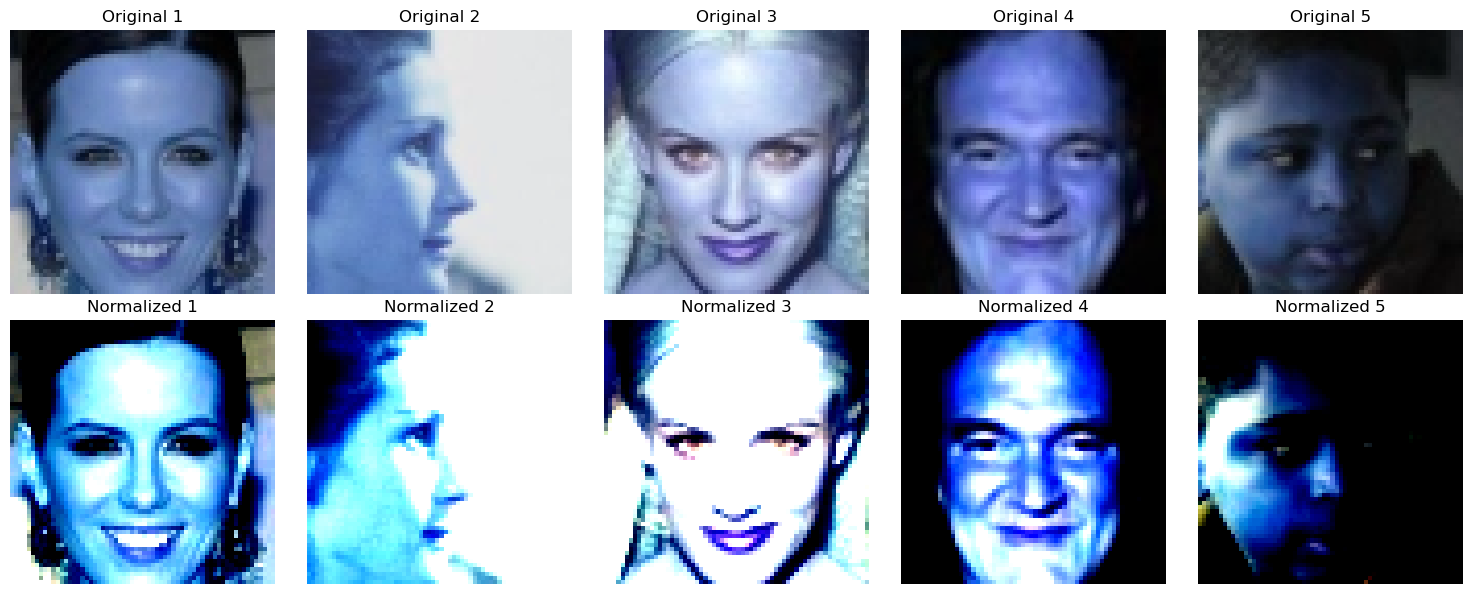

In [86]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = random.sample(range(0, len(images)), num_samples)

# Create a figure for displaying images (2 rows: 1 for original, 1 for normalized)
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Ensure axes is iterable even if there's only one axis
if num_samples == 1:
    axes = [axes]

# Loop through each random index and display the corresponding images
for i, idx in enumerate(random_indices):
    # Get the original image
    original_image = images[idx].astype("uint8")
    
    # Get the normalized image
    normalized_image = normalized_features[idx].astype("float32")

    # Display the original image
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Display the normalized image
    axes[1, i].imshow(normalized_image)
    axes[1, i].set_title(f"Normalized {i+1}")
    axes[1, i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## SPLIT DATA

In [15]:

# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_features, labels, test_size=0.3, random_state=123, stratify=labels)

# Split the temp data into validation and test sets (50% validation, 50% test of the 30% left)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

## Check the shapes of the splits

In [17]:
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Validation set size: {X_val.shape}, {y_val.shape}")
print(f"Test set size: {X_test.shape}, {y_test.shape}")

Training set size: (10255, 64, 64, 3), (10255,)
Validation set size: (2197, 64, 64, 3), (2197,)
Test set size: (2198, 64, 64, 3), (2198,)


## Data Augmentation

In [19]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)


## Balance Dataset using SMOTE

In [21]:
X_train_flat = X_train.reshape(len(X_train), -1)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)
X_train_balanced = X_train_balanced.reshape(-1, 64, 64, 3)
print(f"Balanced training set size: {X_train_balanced.shape[0]} images")

Balanced training set size: 40194 images


## ENCODER DECODER(before CV)

In [22]:
encoding_dim = 128  # Latent space dimension (increase size for better performance)

# Build the autoencoder model
input_img = tf.keras.Input(shape=(64, 64, 3))

# Flatten the input image to 1D vector
x = tf.keras.layers.Flatten()(input_img)

# Encoder: Multiple Dense layers to progressively compress the image into a latent representation
x = tf.keras.layers.Dense(1024, activation='relu')(x)  # First hidden layer
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Second hidden layer

encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)  # Latent space layer

# Decoder: Multiple Dense layers to progressively reconstruct the image from the latent representation
x = tf.keras.layers.Dense(512, activation='relu')(encoded)  # First hidden layer of the decoder
x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Second hidden layer of the decoder
decoded = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)  # Output layer with 'sigmoid'

# Reshape the decoded output back into the original image shape
decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)

# Define the model that takes an image and outputs the reconstructed image
autoencoder = tf.keras.Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

# Display the summary of the model to verify the architecture
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12288)          │    12,595,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,360,960 (100.56 MB)

 Trainable params: 26,360,960 (100.56 MB)

 Non-trainable params: 0 (0.00 B)

## APPLY CROSS VALIDATION

In [41]:
# Function to build the autoencoder model with parameterized layers and neurons
def build_autoencoder(neurons_per_layer, encoding_dim=128):
    input_img = tf.keras.Input(shape=(64, 64, 3))
    x = tf.keras.layers.Flatten()(input_img)

    # Encoder: Add layers based on the neuron configuration
    for neurons in neurons_per_layer:
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)

    # Latent space
    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)

    # Decoder: Reverse the layer configuration
    x = encoded
    for neurons in reversed(neurons_per_layer):
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)

    # Output layer: Reconstruct the image
    decoded = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)
    decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)

    # Compile the model
    autoencoder = tf.keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return autoencoder

# Example dataset (replace this with your actual data)
X = np.random.rand(10255, 64, 64, 3)  # Example: 10255 images of 64x64 with 3 channels

# Hyperparameter search space
layer_neuron_combinations = [
    [128],          # Single layer with 128 neurons
    [128, 256],     # Two layers: first with 128 neurons, second with 256
    [256, 512],     # Two layers: first with 256 neurons, second with 128
    [128, 256, 512] # Three layers: 128 -> 256 -> 512
]

# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Sampling size
sample_fraction = 0.1  # Use 10% of the training set in each fold

for neuron_config in layer_neuron_combinations:
    print(f"Testing configuration: {neuron_config} neurons per layer")
    fold_losses = []

    # Perform K-Fold Cross-Validation
    for train_idx, val_idx in kfold.split(X):
        # Split the dataset into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]

        # Take a random sample of the training data
        train_sample_size = int(len(X_train) * sample_fraction)
        sampled_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
        X_train_sampled = X_train[sampled_indices]

        # Build the autoencoder model
        autoencoder = build_autoencoder(neurons_per_layer=neuron_config)

        # Train the model
        history = autoencoder.fit(
            X_train_sampled, X_train_sampled,  # Input is the target (autoencoder)
            validation_data=(X_val, X_val),
            epochs=10,  # Adjust as needed
            batch_size=32,
            verbose=0
        )

        # Record validation loss for the fold
        val_loss = history.history['val_loss'][-1]
        fold_losses.append(val_loss)

    # Compute the average validation loss for the configuration
    avg_val_loss = np.mean(fold_losses)
    results[tuple(neuron_config)] = avg_val_loss
    print(f"Average Validation Loss for {neuron_config}: {avg_val_loss}")

# Find the best configuration
best_config = min(results, key=results.get)
print(f"Best Configuration: {best_config} with Loss: {results[best_config]}")


Testing configuration: [128] neurons per layer
Average Validation Loss for [128]: 0.08340911567211151
Testing configuration: [128, 256] neurons per layer
Average Validation Loss for [128, 256]: 0.08338384628295899
Testing configuration: [256, 512] neurons per layer
Average Validation Loss for [256, 512]: 0.08340034037828445
Testing configuration: [128, 256, 512] neurons per layer
Average Validation Loss for [128, 256, 512]: 0.08340479880571365
Best Configuration: (128, 256) with Loss: 0.08338384628295899


## New cross validation 

In [25]:
# Function to build the autoencoder model with parameterized layers and neurons
def build_autoencoder(neurons_per_layer, encoding_dim=128):
    input_img = tf.keras.Input(shape=(64, 64, 3))
    x = tf.keras.layers.Flatten()(input_img)

    # Encoder: Add layers based on the neuron configuration
    for neurons in neurons_per_layer:
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)

    # Latent space
    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)

    # Decoder: Reverse the layer configuration
    x = encoded
    for neurons in reversed(neurons_per_layer):
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)

    # Output layer: Reconstruct the image
    decoded = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)
    decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)

    # Compile the model
    autoencoder = tf.keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return autoencoder

# Example dataset (replace this with your actual data)
X = np.random.rand(10255, 64, 64, 3)  # Example: 10255 images of 64x64 with 3 channels

# Hyperparameter search space
layer_neuron_combinations = [
    [256],                   # Single layer with 256 neurons
    [512, 256, 128],         # Three layers: 512 -> 256 -> 128 (reverse pyramid)
    [128, 256, 512, 256],    # Four layers: 128 -> 256 -> 512 -> 256
    [256, 512, 1024, 512],   # Four layers: 256 -> 512 -> 1024 -> 512
    [128, 256, 512, 1024],   # Four layers: 128 -> 256 -> 512 -> 1024
    [512, 1024, 512, 256],   # Four layers: 512 -> 1024 -> 512 -> 256
]


# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Sampling size
sample_fraction = 0.1  # Use 10% of the training set in each fold

for neuron_config in layer_neuron_combinations:
    print(f"Testing configuration: {neuron_config} neurons per layer")
    fold_losses = []

    # Perform K-Fold Cross-Validation
    for train_idx, val_idx in kfold.split(X):
        # Split the dataset into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]

        # Take a random sample of the training data
        train_sample_size = int(len(X_train) * sample_fraction)
        sampled_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
        X_train_sampled = X_train[sampled_indices]

        # Build the autoencoder model
        autoencoder = build_autoencoder(neurons_per_layer=neuron_config)

        # Train the model
        history = autoencoder.fit(
            X_train_sampled, X_train_sampled,  # Input is the target (autoencoder)
            validation_data=(X_val, X_val),
            epochs=10,  # Adjust as needed
            batch_size=32,
            verbose=0
        )

        # Record validation loss for the fold
        val_loss = history.history['val_loss'][-1]
        fold_losses.append(val_loss)

    # Compute the average validation loss for the configuration
    avg_val_loss = np.mean(fold_losses)
    results[tuple(neuron_config)] = avg_val_loss
    print(f"Average Validation Loss for {neuron_config}: {avg_val_loss}")

# Find the best configuration
best_config = min(results, key=results.get)
print(f"Best Configuration: {best_config} with Loss: {results[best_config]}")


Testing configuration: [256] neurons per layer
Average Validation Loss for [256]: 0.08340910822153091
Testing configuration: [512, 256, 128] neurons per layer
Average Validation Loss for [512, 256, 128]: 0.08339153975248337
Testing configuration: [128, 256, 512, 256] neurons per layer
Average Validation Loss for [128, 256, 512, 256]: 0.08339567333459855
Testing configuration: [256, 512, 1024, 512] neurons per layer
Average Validation Loss for [256, 512, 1024, 512]: 0.0834017589688301
Testing configuration: [128, 256, 512, 1024] neurons per layer
Average Validation Loss for [128, 256, 512, 1024]: 0.08340140581130981
Testing configuration: [512, 1024, 512, 256] neurons per layer
Average Validation Loss for [512, 1024, 512, 256]: 0.08340302109718323
Best Configuration: (512, 256, 128) with Loss: 0.08339153975248337


## Re apply splitting

In [27]:

# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_features, labels, test_size=0.3, random_state=123, stratify=labels)

# Split the temp data into validation and test sets (50% validation, 50% test of the 30% left)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

## Data Augmentation and Balance Dataset using SMOTE

In [29]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

# Balance Dataset using SMOTE
X_train_flat = X_train.reshape(len(X_train), -1)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)
X_train_balanced = X_train_balanced.reshape(-1, 64, 64, 3)
print(f"Balanced training set size: {X_train_balanced.shape[0]} images")

Balanced training set size: 40194 images


## ENCODER DECODER(after CV)

In [32]:
encoding_dim = 128  # Latent space dimension (increase size for better performance)

# Build the autoencoder model
input_img = tf.keras.Input(shape=(64, 64, 3))

# Flatten the input image to 1D vector
x = tf.keras.layers.Flatten()(input_img)

# Encoder: Multiple Dense layers to progressively compress the image into a latent representation
x = tf.keras.layers.Dense(256, activation='relu')(x)  # First hidden layer
x = tf.keras.layers.Dense(128, activation='relu')(x)  # Second hidden layer

encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)  # Latent space layer

# Decoder: Multiple Dense layers to progressively reconstruct the image from the latent representation
x = tf.keras.layers.Dense(128, activation='relu')(encoded)  # First hidden layer of the decoder
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Second hidden layer of the decoder
decoded = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)  # Output layer with 'sigmoid'

# Reshape the decoded output back into the original image shape
decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)

# Define the model that takes an image and outputs the reconstructed image
autoencoder = tf.keras.Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

# Display the summary of the model to verify the architecture
autoencoder.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 256)            │     3,145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 12288)          │     3,158,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_31 (Reshape)            │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,402,944 (24.43 MB)

 Trainable params: 6,402,944 (24.43 MB)

 Non-trainable params: 0 (0.00 B)

## Train the autoencoder and reshaped images

In [35]:
# Reshape the data to match input shape for training
X_train_reshaped = X_train.reshape(-1, 64, 64, 3)
X_val_reshaped = X_val.reshape(-1, 64, 64, 3)
X_test_reshaped = X_test.reshape(-1, 64, 64, 3)

# Train the autoencoder with reshaped images
history = autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=32, shuffle=True, validation_data=(X_val_reshaped, X_val_reshaped))

# After training, extract the encoder part of the autoencoder to get the encoded features
encoder = tf.keras.Model(input_img, encoded)
#encoder.save("encoder.h5")


Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6759 - loss: 0.5606 - val_accuracy: 0.7486 - val_loss: 0.4496
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7570 - loss: 0.4397 - val_accuracy: 0.7722 - val_loss: 0.4327
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.7688 - loss: 0.4259 - val_accuracy: 0.7701 - val_loss: 0.4232
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7802 - loss: 0.4155 - val_accuracy: 0.7760 - val_loss: 0.4198
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.7838 - loss: 0.4119 - val_accuracy: 0.7892 - val_loss: 0.4154
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7885 - loss: 0.4116 - val_accuracy: 0.7893 - val_loss: 0.4131
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7925 - loss: 0.4033 - val_accuracy: 0.7938 - val_loss: 0.4109
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7939 - loss: 0.4065 - 

## Extract the encoded features for the training, validation, and test sets

In [37]:
#encoder = load_model("encoder.h5")
encoded_features_train = encoder.predict(X_train_reshaped)
encoded_features_val = encoder.predict(X_val_reshaped)
encoded_features_test = encoder.predict(X_test_reshaped)

encoded_features_train = encoded_features_train.reshape(encoded_features_train.shape[0], -1)
encoded_features_val = encoded_features_val.reshape(encoded_features_val.shape[0], -1)
encoded_features_test = encoded_features_test.reshape(encoded_features_test.shape[0], -1)

321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Display the Original and Reconstructed images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


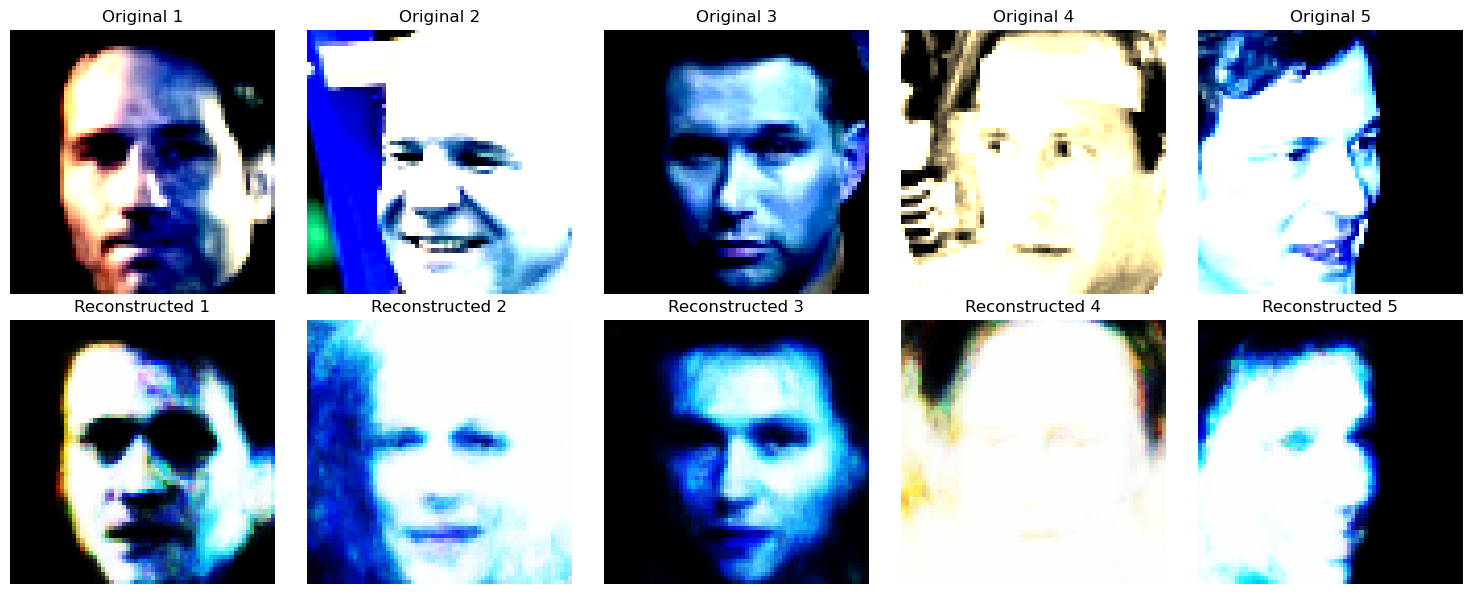

In [64]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, X_train_reshaped.shape[0], num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    # Get the original image
    original_image = X_train_reshaped[idx]

    # Reconstruct the image using the autoencoder
    reconstructed_image = autoencoder.predict(np.expand_dims(original_image, axis=0))

    # Normalize the images to the range [0, 1]
    original_image = np.clip(original_image, 0, 1)
    reconstructed_image = np.clip(reconstructed_image[0], 0, 1)

    # Display the original image in the first row
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Display the reconstructed image in the second row
    axes[1, i].imshow(reconstructed_image)
    axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## VIsualization

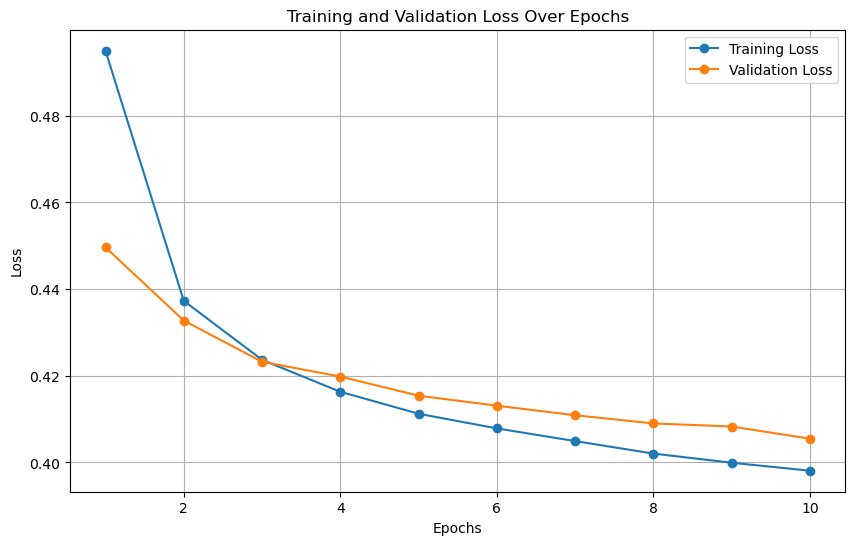

In [67]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Own implementation of the KNN algorithm

In [70]:
def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance

class the_minimum_Euclidean_distance_classifier:
    def __init__(self, k=3): #we make default 3 the votes might be 2:1, ensuring a clear winner smaller than will be no winner or overfitting
        self.k = k

    def fit(self, X, y): #fit means stores our trainnig set
        self.X_train = X    
        self.y_train = y

    def _predict(self, x):
        # compute the distance
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train] #x is the test set from xtrain to last value in x_train 
    
        # get the closest k
        k_indices_feature = np.argsort(distances)[:self.k] ## sorting ascending order to find the nearest point and determine which class belongs
        k_nearest_labels = [self.y_train[i] for i in k_indices_feature]

        # majority voye
        most_common = Counter(k_nearest_labels).most_common()  ## to count the occurrences of each element in an iterable (like a list).
        return most_common[0][0]  ##first element in first label
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

## KNN classifier built with a manually implemented KNN algorithm

In [73]:
classifier = the_minimum_Euclidean_distance_classifier(k=1)
classifier.fit(encoded_features_train, y_train)
y_pred = classifier.predict(encoded_features_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")  

Recognition Accuracy: 27.39%


## KNN classifier using the scikit-learn library

In [75]:
# Train the classifier on the encoded features of the training set
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(encoded_features_test)

# Evaluate the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")

Recognition Accuracy: 27.39%


## Display a random image from the test set along with its true and predicted labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


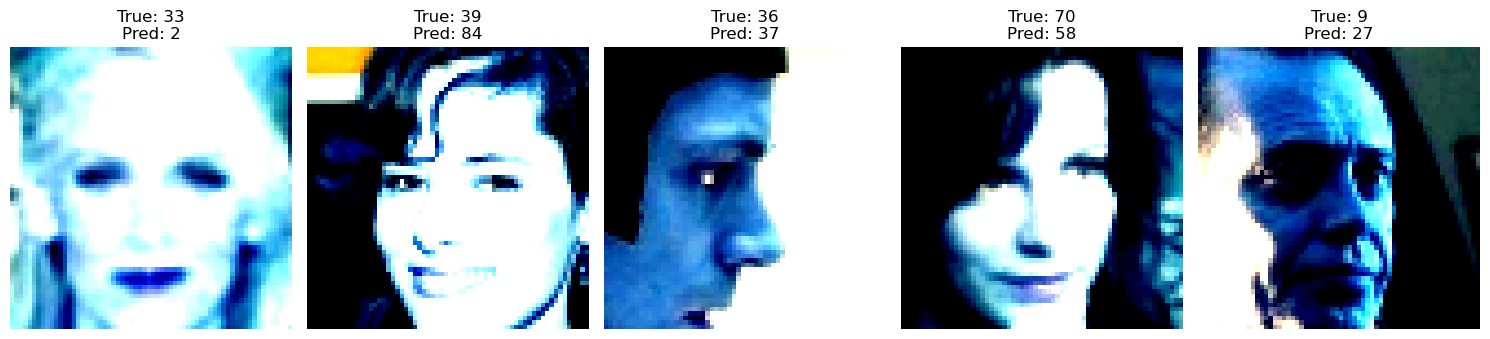

In [80]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, len(X_test), num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# Ensure axes is iterable even if there's only one axis
if num_samples == 1:
    axes = [axes]

for i, idx in enumerate(random_indices):
    # Get the test image and its true label
    test_image = X_test[idx]
    true_label = y_test[idx]
    
    # Check if the image is normalized (values between 0 and 1)
    if test_image.max() <= 1:  # Likely normalized, rescale to 0-255 range
        test_image = (test_image * 255).astype(np.uint8)

    # Clip the image values to the valid range [0, 255] for display
    test_image = np.clip(test_image, 0, 255)

    # Get the predicted label using KNN
    predicted_label = knn.predict([encoded_features_test[idx]])[0]
    
    # Display the image
    if len(test_image.shape) == 2:  # Grayscale image
        axes[i].imshow(test_image, cmap='gray')
    else:  # RGB image
        axes[i].imshow(test_image)

    # Display the true and predicted labels as titles
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')  # Hide axes for better visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
